In [9]:
from dotenv import load_dotenv
import os, pathlib

ENV_PATH = str(pathlib.Path.home() / "llamp" / ".env.local")
load_dotenv(ENV_PATH, override=True)

for k in ["PMG_MAPI_KEY","MP_API_KEY","GOOGLE_API_KEY"]:
    v = os.getenv(k)
    print(k, "SET" if v else "MISSING", f"(len={len(v)})" if v else "")

PMG_MAPI_KEY SET (len=32)
MP_API_KEY SET (len=32)
GOOGLE_API_KEY SET (len=39)


In [10]:
import os, pathlib, json

ROOT = pathlib.Path.home() / "llamp_hallu_exp"
DATA_DIR = ROOT / "data"
PROMPT_DIR = ROOT / "prompts"
LOG_DIR = ROOT / "logs"
RESULT_DIR = ROOT / "results"
ANNOT_DIR = ROOT / "annotation"

for d in [DATA_DIR, PROMPT_DIR, LOG_DIR, RESULT_DIR, ANNOT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Created:", ROOT)

Created: /Users/yutongduan/llamp_hallu_exp


In [5]:
from mp_api.client import MPRester
import os

key = os.getenv("PMG_MAPI_KEY") or os.getenv("MP_API_KEY")
assert key, "No MP API key found!"

FIELDS = ["material_id", "band_gap", "formation_energy_per_atom", "energy_above_hull", "is_metal"]

with MPRester(key) as mpr:
    docs = mpr.materials.summary.search(
        fields=FIELDS,
        chunk_size=1000,
        num_chunks=1,
    )

print("downloaded docs:", len(docs))
print("first id:", docs[0].material_id)

Retrieving SummaryDoc documents: 100%|██████████| 1000/1000 [00:00<00:00, 2314737.31it/s]

downloaded docs: 1000
first id: mp-1094120


In [6]:
import pandas as pd

rows = []
for d in docs:
    rows.append({
        "material_id": str(d.material_id),
        "band_gap": d.band_gap,
        "formation_energy_per_atom": d.formation_energy_per_atom,
        "energy_above_hull": d.energy_above_hull,
        "is_metal": d.is_metal,
    })

df = pd.DataFrame(rows)

df_f = df[
    (df["energy_above_hull"] == 0.0) &
    (df["band_gap"].notna()) &
    (df["band_gap"] >= 0.1) &
    (df["formation_energy_per_atom"].notna())
].reset_index(drop=True)

print("candidates after filter:", len(df_f))
df_f.head()

candidates after filter: 22


,material_id,band_gap,formation_energy_per_atom,energy_above_hull,is_metal
0,mp-12957,1.0933,0.0,0.0,False
1,mp-1524462,2.7061,0.0,0.0,False
2,mp-3347313,1.3762,0.0,0.0,False
3,mp-568348,1.8454,0.0,0.0,False
4,mp-570481,1.7696,0.0,0.0,False


day 2

In [12]:
import time, json, re

def llm_call_json(prompt: str):
    """
    Call your LLM once, return (pred_dict, raw_text, latency_seconds).
    Works for ChatGoogleGenerativeAI (Gemini) and most LangChain chat models.
    """
    t0 = time.time()

    # 兼容：不同版本 langchain_google_genai 返回类型不完全一样
    resp = top_llm.invoke(prompt)

    # resp 可能是 AIMessage，也可能直接是 str
    if isinstance(resp, str):
        raw = resp
    else:
        raw = getattr(resp, "content", str(resp))

    latency = time.time() - t0

    # 复用你之前的 safe_json_load（如果你已经定义过）
    try:
        pred = safe_json_load(raw)
    except NameError:
        # fallback：如果你还没定义 safe_json_load，就用一个简化版
        s = raw.strip()
        m = re.search(r"\{.*\}", s, flags=re.S)
        if m:
            s = m.group(0)
        pred = json.loads(s)

    return pred, raw, latency

In [13]:
import pandas as pd
gt = pd.read_csv("gt_100.csv")
gt.head()

,material_id,band_gap,is_metal,energy_above_hull,is_stable
0,mp-1018138,1.0370,False,0.0,True
1,mp-1018722,1.0432,False,0.0,True
2,mp-1025442,1.3847,False,0.0,True
3,mp-10802,0.5879,False,0.0,True
4,mp-1095275,0.4889,False,0.0,True


In [19]:
from langchain_google_genai import ChatGoogleGenerativeAI

GEMINI_MODEL = "models/gemini-2.5-flash-lite"  # 你 list_models 里有这个
top_llm = ChatGoogleGenerativeAI(
    model=GEMINI_MODEL,
    temperature=0.0,
    convert_system_message_to_human=True,  # 避免 SystemMessage 报错
)
print("top_llm built:", GEMINI_MODEL)

top_llm built: models/gemini-2.5-flash-lite


In [21]:
import time, json, re

# --------- 1) make missing record ----------
def make_record_missing_band_gap(gt_row: dict):
    # 只给模型“证据的一部分”：故意删掉 band_gap
    # 你可以按需保留更多字段，这里保留最常用的 4 个
    return {
        "material_id": gt_row["material_id"],
        "is_metal": gt_row["is_metal"],
        "energy_above_hull": gt_row["energy_above_hull"],
        "is_stable": gt_row["is_stable"],
        # band_gap 故意不提供
    }

# --------- 2) prompt ----------
def build_prompt_missing_band_gap(mp_record: dict) -> str:
    return f"""
You are given a Materials Project record as JSON.

RULES:
- Use ONLY the values in the JSON. Do NOT guess or add anything.
- If a required value is not present in the JSON, output null for that value.
- Output MUST be valid JSON only (no markdown, no extra text).

JSON record:
{json.dumps(mp_record, ensure_ascii=False)}

Return JSON with exactly these keys:
material_id (string),
band_gap_eV (number or null),
is_metal (boolean),
energy_above_hull_eV (number),
is_stable (boolean)
""".strip()

# --------- 3) safe json load ----------
def safe_json_load(s: str):
    s = s.strip()
    m = re.search(r"\{.*\}", s, flags=re.S)
    if m:
        s = m.group(0)
    return json.loads(s)

# --------- 4) llm call ----------
def llm_call_json(prompt: str):
    t0 = time.time()
    resp = top_llm.invoke(prompt)  # 需要你已经定义好 top_llm
    raw = resp if isinstance(resp, str) else getattr(resp, "content", str(resp))
    latency = time.time() - t0
    pred = safe_json_load(raw)
    return pred, raw, latency

# --------- 5) judge: hallucination for missing band_gap ----------
def judge_missing_band_gap(input_record: dict, gt_row: dict, pred: dict):
    """
    目标：
    - band_gap 在 input_record 里缺失 => 模型应该输出 null
    - 如果模型输出了数字 => 这是 hallucination（intrinsic_unfaithful: fabricated_missing_field）
    同时检查其它字段是否抄对（保证它没乱编其它字段）
    """
    required_keys = ["material_id","band_gap_eV","is_metal","energy_above_hull_eV","is_stable"]
    for k in required_keys:
        if k not in pred:
            return False, "format_missing_keys", f"missing_key:{k}"

    # material_id 必须一致
    if str(pred["material_id"]) != str(gt_row["material_id"]):
        return False, "format_wrong_id", "wrong_material_id"

    # 其它字段要能对上（用 input_record/gt_row 作为真值）
    if bool(pred["is_metal"]) != bool(gt_row["is_metal"]):
        return False, "intrinsic_unfaithful", "is_metal_mismatch"

    try:
        if float(pred["energy_above_hull_eV"]) != float(gt_row["energy_above_hull"]):
            return False, "intrinsic_unfaithful", "e_above_hull_mismatch"
    except Exception:
        return False, "format_parse_error", "e_above_hull_parse_error"

    if bool(pred["is_stable"]) != bool(gt_row["is_stable"]):
        return False, "intrinsic_unfaithful", "is_stable_mismatch"

    # 核心：band_gap 缺失时必须 null
    if pred["band_gap_eV"] is None:
        return True, "ok_abstain", ""
    else:
        # 只要给了数，就是编的（因为证据里没有）
        return False, "intrinsic_unfaithful", "fabricated_missing_band_gap"

In [22]:
pilot_n = 10
rows = []
for i in range(pilot_n):
    gt_row = gt.iloc[i].to_dict()
    input_record = make_record_missing_band_gap(gt_row)
    prompt = build_prompt_missing_band_gap(input_record)

    pred, raw, latency = llm_call_json(prompt)
    ok, label, detail = judge_missing_band_gap(input_record, gt_row, pred)

    rows.append({
        "material_id": gt_row["material_id"],
        "gt_band_gap": gt_row["band_gap"],
        "input_missing": "band_gap",
        "pred_band_gap_eV": pred.get("band_gap_eV", None),
        "label": label,
        "detail": detail,
        "raw_text": raw,
        "latency_s": latency,
    })

import pandas as pd
df_pilot = pd.DataFrame(rows)
print(df_pilot["label"].value_counts(dropna=False))
df_pilot.head()
df_pilot.to_csv("pilot_missing_band_gap_10.csv", index=False)
print("saved pilot_missing_band_gap_10.csv")

label
ok_abstain    10
Name: count, dtype: int64
saved pilot_missing_band_gap_10.csv


In [23]:
rows = []
for i in range(len(gt)):
    gt_row = gt.iloc[i].to_dict()
    input_record = make_record_missing_band_gap(gt_row)
    prompt = build_prompt_missing_band_gap(input_record)

    pred, raw, latency = llm_call_json(prompt)
    ok, label, detail = judge_missing_band_gap(input_record, gt_row, pred)

    rows.append({
        "material_id": gt_row["material_id"],
        "gt_band_gap": gt_row["band_gap"],
        "input_missing": "band_gap",
        "pred_band_gap_eV": pred.get("band_gap_eV", None),
        "label": label,
        "detail": detail,
        "latency_s": latency,
    })

df = pd.DataFrame(rows)
print(df["label"].value_counts(dropna=False))

# 幻觉率（只看“band_gap 缺失时仍输出数”）
hallu_rate = (df["label"].isin(["hallucination_guess","hallucination_lucky"])).mean()
print("hallucination_rate:", hallu_rate)

df.to_csv("missing_band_gap_100.csv", index=False)
print("saved missing_band_gap_100.csv")

label
ok_abstain    100
Name: count, dtype: int64
hallucination_rate: 0.0
saved missing_band_gap_100.csv


In [24]:
import re, time, pandas as pd, random

def build_query_band_gap(mpid: str) -> str:
    # baseline: no tool, no record
    return f"What is the band gap (eV) of material {mpid}? Answer with a single number."

def parse_first_float(text: str):
    m = re.search(r"[-+]?\d*\.\d+|\d+", text)
    return float(m.group(0)) if m else None

def is_refusal(text: str):
    t = text.lower()
    return any(x in t for x in ["cannot", "can't", "unable", "not sure", "do not know", "don't know", "unknown"])

rows = []
# 先跑 30 条试运行
sample = gt.sample(n=30, random_state=42).reset_index(drop=True)

for i in range(len(sample)):
    mpid = str(sample.loc[i, "material_id"])
    gt_bg = float(sample.loc[i, "band_gap"])

    q = build_query_band_gap(mpid)

    t0 = time.time()
    resp = top_llm.invoke(q)
    raw = resp if isinstance(resp, str) else getattr(resp, "content", str(resp))
    latency = time.time() - t0

    pred = parse_first_float(raw)

    # 判定：给个 tolerance（先 0.05 eV）
    tol = 0.05
    if pred is None:
        label = "parse_fail"
        correct = False
    elif is_refusal(raw):
        label = "refusal"
        correct = False
    elif abs(pred - gt_bg) <= tol:
        label = "ok"
        correct = True
    else:
        label = "wrong_value"
        correct = False

    rows.append({
        "material_id": mpid,
        "gt_band_gap": gt_bg,
        "query": q,
        "raw_output": raw,
        "pred_band_gap": pred,
        "label": label,
        "is_correct": correct,
        "latency_s": latency,
    })

df_base = pd.DataFrame(rows)
print(df_base["label"].value_counts(dropna=False))
print("accuracy:", df_base["is_correct"].mean())

out_path = "baseline_band_gap_30.csv"
df_base.to_csv(out_path, index=False)
print("saved:", out_path)

label
wrong_value    29
ok              1
Name: count, dtype: int64
accuracy: 0.03333333333333333
saved: baseline_band_gap_30.csv


In [25]:
import pandas as pd, numpy as np

df = pd.read_csv("baseline_band_gap_30.csv")
df["abs_err"] = (df["pred_band_gap"] - df["gt_band_gap"]).abs()
print(df["abs_err"].describe())

# 看看不同容忍度下的 accuracy（有时候0.05太严）
for tol in [0.05, 0.1, 0.2, 0.5]:
    acc = (df["abs_err"] <= tol).mean()
    print("tol =", tol, "acc =", acc)

# 看最离谱的 5 个
df.sort_values("abs_err", ascending=False).head(5)[
    ["material_id","gt_band_gap","pred_band_gap","abs_err","raw_output"]
]

count    30.000000
mean      1.262420
std       1.364391
min       0.048100
25%       0.551700
50%       0.863050
75%       1.324950
max       7.213200
Name: abs_err, dtype: float64
tol = 0.05 acc = 0.03333333333333333
tol = 0.1 acc = 0.03333333333333333
tol = 0.2 acc = 0.03333333333333333
tol = 0.5 acc = 0.2


,material_id,gt_band_gap,pred_band_gap,abs_err,raw_output
26,mp-23155,8.5132,1.3,7.2132,1.3
20,mp-27972,4.1033,1.3,2.8033,1.3
5,mp-22909,4.0533,1.3,2.7533,1.3
3,mp-23280,3.9873,1.3,2.6873,1.3
21,mp-6949,4.0226,1.5,2.5226,1.5


In [26]:
df[df["label"]=="wrong_value"].sample(5, random_state=0)[
    ["material_id","gt_band_gap","pred_band_gap","raw_output"]
]

,material_id,gt_band_gap,pred_band_gap,raw_output
2,mp-384,0.7289,1.5,1.5
21,mp-6949,4.0226,1.5,1.5
24,mp-34202,0.3388,1.3,1.3
13,mp-2049132,0.2163,1.3,1.3
11,mp-18388,0.5754,1.3,1.3


In [27]:
df["pred_band_gap"].value_counts().head(20)

pred_band_gap
1.3    20
1.5    10
Name: count, dtype: int64

In [32]:
from mp_api.client import MPRester
import os, pandas as pd

key = os.getenv("PMG_MAPI_KEY") or os.getenv("MP_API_KEY")
FIELDS = ["material_id","band_gap","formation_energy_per_atom","energy_above_hull","is_metal","is_stable"]

all_docs = []
with MPRester(key) as mpr:
    # 先拉 10000（你之前成功过），再自己过滤
    docs = mpr.materials.summary.search(fields=FIELDS, chunk_size=1000, num_chunks=10)
    all_docs = docs

df = pd.DataFrame([{
    "material_id": str(d.material_id),
    "band_gap": d.band_gap,
    "formation_energy_per_atom": d.formation_energy_per_atom,
    "energy_above_hull": d.energy_above_hull,
    "is_metal": d.is_metal,
    "is_stable": d.is_stable
} for d in all_docs])

cand = df[(df["is_stable"]==True) & (df["is_metal"]==False) & (df["band_gap"]>=0.1)].copy()
print("downloaded:", len(df), "candidates:", len(cand))

Retrieving SummaryDoc documents: 100%|██████████| 10000/10000 [00:02<00:00, 4602.17it/s]

downloaded: 10000 candidates: 507


In [ ]:
ids = cand["material_id"].astype(str).tolist()
ids = list(dict.fromkeys(ids))  # 去重保序
print("unique ids in cand:", len(ids))

random.seed(42)
sample_ids = random.sample(ids, k=200)

unique ids in cand: 507


ValueError: Cannot take a larger sample than population when 'replace=False'

In [38]:
import random, pandas as pd

ids = cand["material_id"].astype(str).tolist()
ids = list(dict.fromkeys(ids))
random.seed(42)
sample_ids = random.sample(ids, k=200)

# 如果 cand 本身就包含你需要的 GT 字段（band_gap 等），直接从 cand 取：
gt_run = cand[cand["material_id"].isin(sample_ids)].copy()
gt_run = gt_run.drop_duplicates("material_id").sample(frac=1, random_state=42).reset_index(drop=True)

print("gt_run size:", len(gt_run))
gt_run.head()

gt_run size: 200


,material_id,band_gap,formation_energy_per_atom,energy_above_hull,is_metal,is_stable
0,mp-619575,2.5175,-0.618293,0.0,False,True
1,mp-9851,0.1063,-0.630045,0.0,False,True
2,mp-2793,0.2628,-0.140219,0.0,False,True
3,mp-23184,4.7135,-1.042661,0.0,False,True
4,mp-1213622,0.5263,-1.597049,0.0,False,True


In [39]:
rows = []
for i in range(len(gt_run)):
    gt_row = gt_run.iloc[i].to_dict()
    mpid = str(gt_row["material_id"])
    input_record = make_record_missing_band_gap(gt_row)
    prompt = build_prompt_missing_band_gap(input_record)

    pred, raw, latency = llm_call_json(prompt)
    ok, label, detail = judge_missing_band_gap(input_record, gt_row, pred)

    rows.append({
        "material_id": gt_row["material_id"],
        "gt_band_gap": gt_row["band_gap"],
        "input_missing": "band_gap",
        "pred_band_gap_eV": pred.get("band_gap_eV", None),
        "label": label,
        "detail": detail,
        "latency_s": latency,
    })

df = pd.DataFrame(rows)
print(df["label"].value_counts(dropna=False))

# 幻觉率（只看“band_gap 缺失时仍输出数”）
hallu_rate = (df["label"].isin(["hallucination_guess","hallucination_lucky"])).mean()
print("hallucination_rate:", hallu_rate)

df.to_csv("baseline_band_gap_200.csv", index=False)
print("saved: baseline_band_gap_200.csv")

label
ok_abstain    200
Name: count, dtype: int64
hallucination_rate: 0.0
saved: baseline_band_gap_200.csv


In [40]:
TEMPLATES = [
    "What is the band gap (eV) of material {mpid}? Answer with a single number.",
    "Give the band gap of {mpid} in eV. No extra text.",
    "Band gap for {mpid} (eV)? Return only the number."
]

In [43]:
import re, time, random
import numpy as np
import pandas as pd

# 1) parser：抓第一个浮点数（baseline 足够）
_float_pat = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")
def parse_first_float(s: str):
    if s is None:
        return None
    m = _float_pat.search(str(s))
    return float(m.group(0)) if m else None

# 2) baseline prompt：明确“只输出一个数字”，减少乱输出（但仍然是 no_tool）
def make_query(mpid: str, tid: int):
    return TEMPLATES[tid].format(mpid=mpid).strip() + " Output only ONE number."

# 3) main loop
random.seed(42)
np.random.seed(42)

tol = 0.05  # 先定死，后面你也可以比较 tol=0.1/0.2/0.5
rows = []

for i in range(len(gt_run)):
    gt_row = gt_run.iloc[i].to_dict()
    mpid = str(gt_row["material_id"])
    gt_bg = float(gt_row["band_gap"])

    tid = random.randrange(len(TEMPLATES))
    query = make_query(mpid, tid)

    t0 = time.time()
    resp = top_llm.invoke(query)
    raw = resp if isinstance(resp, str) else getattr(resp, "content", str(resp))
    latency = time.time() - t0

    pred = parse_first_float(raw)
    abs_err = abs(pred - gt_bg) if pred is not None else None

    # label：baseline 三分类就够
    if pred is None:
        label = "parse_fail"
    elif abs_err <= tol:
        label = "ok"
    else:
        label = "wrong_value"

    rows.append({
        "material_id": mpid,
        "gt_band_gap": gt_bg,
        "template_id": tid,
        "query": query,
        "pred_band_gap": pred,
        "abs_err": abs_err,
        "label": label,
        "raw_output": raw,
        "latency_s": latency,
    })

df = pd.DataFrame(rows)
df.to_csv("baseline_band_gap_200.csv", index=False)

print("saved: baseline_band_gap_200.csv")
print(df["label"].value_counts(dropna=False))
print("acc(tol=0.05) =", (df["label"]=="ok").mean())
print(df["pred_band_gap"].value_counts().head(10))
print(df["abs_err"].describe())

saved: baseline_band_gap_200.csv
label
wrong_value    199
ok               1
Name: count, dtype: int64
acc(tol=0.05) = 0.005
pred_band_gap
1.70    63
1.50    40
1.30    38
1.75    36
1.35    13
1.80     2
1.53     2
1.10     2
0.10     1
0.15     1
Name: count, dtype: int64
count    200.000000
mean       1.308028
std        1.281923
min        0.036100
25%        0.603475
50%        0.968100
75%        1.484900
max        8.219700
Name: abs_err, dtype: float64


In [44]:
from mp_api.client import MPRester
import os, time, re
import pandas as pd
import numpy as np

key = os.getenv("PMG_MAPI_KEY") or os.getenv("MP_API_KEY")
assert key and len(key) == 32

_float_pat = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")
def parse_first_float(s: str):
    m = _float_pat.search(str(s))
    return float(m.group(0)) if m else None

def grounded_prompt(mpid: str, tool_bg: float):
    # 关键：把“工具返回值”直接给模型，并强制只输出一个数字
    return f"""You MUST use the provided tool result only.
Material: {mpid}
Tool band gap (eV): {tool_bg}

Output only ONE number (the band gap in eV)."""

tol = 0.05
rows = []

# 1) 批量取工具值（跟你之前一样分 batch）
mpids = [str(x) for x in gt_run["material_id"].tolist()]
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

tool_map = {}
with MPRester(key) as mpr:
    for batch in chunks(mpids, 25):
        docs = mpr.materials.summary.search(material_ids=batch, fields=["material_id","band_gap"])
        for d in docs:
            tool_map[str(d.material_id)] = float(d.band_gap)

# 2) LLM 复述 + 评估
for i in range(len(gt_run)):
    gt_row = gt_run.iloc[i].to_dict()
    mpid = str(gt_row["material_id"])
    gt_bg = float(gt_row["band_gap"])
    tool_bg = tool_map.get(mpid, None)

    if tool_bg is None:
        rows.append({"material_id": mpid, "gt_band_gap": gt_bg, "tool_band_gap": None,
                     "pred_band_gap": None, "abs_err": None, "label": "tool_missing",
                     "raw_output": "", "latency_s": None})
        continue

    prompt = grounded_prompt(mpid, tool_bg)

    t0 = time.time()
    resp = top_llm.invoke(prompt)
    raw = resp if isinstance(resp, str) else getattr(resp, "content", str(resp))
    latency = time.time() - t0

    pred = parse_first_float(raw)
    abs_err = abs(pred - gt_bg) if pred is not None else None

    # post-check：如果模型没按要求输出 or 输出错，就判为 grounded_fail（你也可以选择直接覆盖为 tool_bg）
    if pred is None:
        label = "parse_fail"
    elif abs(pred - tool_bg) > 1e-12:   # 必须和工具值完全一致（复述任务就该严格）
        label = "grounded_mismatch"
    else:
        label = "ok"

    rows.append({
        "material_id": mpid,
        "gt_band_gap": gt_bg,
        "tool_band_gap": tool_bg,
        "pred_band_gap": pred,
        "abs_err": abs_err,
        "label": label,
        "raw_output": raw,
        "latency_s": latency,
    })

df_g = pd.DataFrame(rows)
df_g.to_csv("tool_grounded_band_gap_200.csv", index=False)

print("saved: tool_grounded_band_gap_200.csv")
print(df_g["label"].value_counts(dropna=False))
print("acc vs GT(tol=0.05) =", ((df_g["abs_err"]<=tol) & (df_g["label"]=="ok")).mean())

Retrieving SummaryDoc documents: 100%|██████████| 25/25 [00:00<00:00, 362829.07it/s]


saved: tool_grounded_band_gap_200.csv
label
ok    200
Name: count, dtype: int64
acc vs GT(tol=0.05) = 1.0


In [45]:
b = pd.read_csv("baseline_band_gap_200.csv")
g = pd.read_csv("tool_grounded_band_gap_200.csv")

def metrics_baseline(df, tol=0.05):
    ok = (df["abs_err"]<=tol).mean()
    parse_fail = df["pred_band_gap"].isna().mean()
    return ok, parse_fail

def metrics_grounded(df, tol=0.05):
    ok = ((df["label"]=="ok") & (df["abs_err"]<=tol)).mean()
    mismatch = (df["label"]=="grounded_mismatch").mean()
    parse_fail = (df["label"]=="parse_fail").mean()
    return ok, mismatch, parse_fail

print("baseline acc, parse_fail:", metrics_baseline(b))
print("grounded acc, mismatch, parse_fail:", metrics_grounded(g))

baseline acc, parse_fail: (0.005, 0.0)
grounded acc, mismatch, parse_fail: (1.0, 0.0, 0.0)


In [46]:
import pandas as pd

b = pd.read_csv("baseline_band_gap_200.csv")

top = b["pred_band_gap"].value_counts().head(10).reset_index()
top.columns = ["pred_band_gap", "count"]
top["ratio"] = top["count"] / len(b)
top

,pred_band_gap,count,ratio
0,1.70,63,0.315
1,1.50,40,0.200
2,1.30,38,0.190
3,1.75,36,0.180
4,1.35,13,0.065
5,1.80,2,0.010
6,1.53,2,0.010
7,1.10,2,0.010
8,0.10,1,0.005
9,0.15,1,0.005


In [47]:
err = b.sort_values("abs_err", ascending=False).head(20)[
    ["material_id","gt_band_gap","pred_band_gap","abs_err","raw_output","query"]
]
err.to_csv("baseline_case_studies_20.csv", index=False)
print("saved baseline_case_studies_20.csv")

saved baseline_case_studies_20.csv


In [48]:
import pandas as pd
import numpy as np

tol = 0.05
df = pd.read_csv("baseline_band_gap_200.csv")

# label
df["label"] = np.where(df["pred_band_gap"].isna(), "parse_fail",
                np.where(df["abs_err"] <= tol, "ok", "wrong_value"))

print(df["label"].value_counts(dropna=False))
print("acc(tol=0.05) =", (df["label"]=="ok").mean())

df.to_csv("baseline_band_gap_200_labeled.csv", index=False)
print("saved baseline_band_gap_200_labeled.csv")

label
wrong_value    199
ok               1
Name: count, dtype: int64
acc(tol=0.05) = 0.005
saved baseline_band_gap_200_labeled.csv


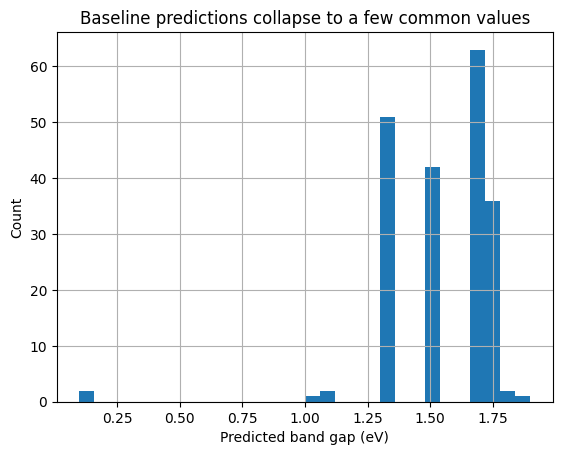

In [49]:
import matplotlib.pyplot as plt

plt.figure()
df["pred_band_gap"].hist(bins=30)
plt.xlabel("Predicted band gap (eV)")
plt.ylabel("Count")
plt.title("Baseline predictions collapse to a few common values")
plt.show()

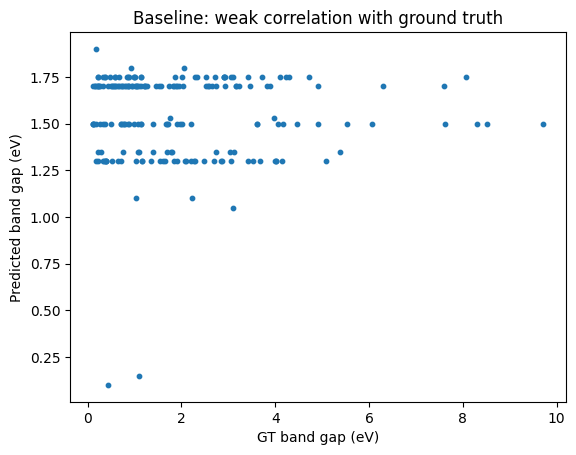

In [50]:
plt.figure()
plt.scatter(df["gt_band_gap"], df["pred_band_gap"], s=10)
plt.xlabel("GT band gap (eV)")
plt.ylabel("Predicted band gap (eV)")
plt.title("Baseline: weak correlation with ground truth")
plt.show()

In [52]:
bad = df.sort_values("abs_err", ascending=False).head(10)

lines = []
for _, r in bad.iterrows():
    lines.append(
f"""### {r['material_id']}
- Query: {r['query']}
- GT band_gap: {r['gt_band_gap']}
- Baseline pred: {r['pred_band_gap']}
- Raw output: {str(r['raw_output']).strip()}
"""
    )

open("case_studies_baseline_top10.md","w").write("\n".join(lines))
print("saved case_studies_baseline_top10.md")

saved case_studies_baseline_top10.md


FORMATION ENERY

In [53]:
from mp_api.client import MPRester
import os, random, time, re
import pandas as pd
import numpy as np

key = os.getenv("PMG_MAPI_KEY") or os.getenv("MP_API_KEY")
assert key is not None and len(key) >= 20, "MP API key not found in env"

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def parse_first_float(s: str):
    s = "" if s is None else str(s)
    m = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
    return float(m.group(0)) if m else None

In [54]:
# 如果你有 baseline_band_gap_200.csv，就用它的 material_id
df_bg = pd.read_csv("baseline_band_gap_200.csv")
sample_ids = df_bg["material_id"].astype(str).tolist()
sample_ids = list(dict.fromkeys(sample_ids))
print("sample_ids:", len(sample_ids))

sample_ids: 200


In [55]:
FIELDS_FE = ["material_id", "formation_energy_per_atom"]

rows = []
with MPRester(key) as mpr:
    for batch in chunks(sample_ids, 100):  # MP endpoint max limit=1000，这里按 batch id 查
        docs = mpr.materials.summary.search(material_ids=batch, fields=FIELDS_FE)
        for d in docs:
            rows.append({
                "material_id": str(d.material_id),
                "gt_fe_per_atom": d.formation_energy_per_atom,
            })

gt_fe = pd.DataFrame(rows).dropna(subset=["gt_fe_per_atom"]).sort_values("material_id").reset_index(drop=True)

# 若过滤后不足 200，就从头再补一些 mpid（一般不会）
print("gt_fe size:", len(gt_fe), "missing:", gt_fe["gt_fe_per_atom"].isna().sum())
gt_fe.to_csv("gt_fe.csv", index=False)
print("saved gt_fe.csv")
gt_fe.head()

Retrieving SummaryDoc documents: 100%|██████████| 100/100 [00:00<00:00, 2086718.41it/s]

gt_fe size: 200 missing: 0
saved gt_fe.csv


,material_id,gt_fe_per_atom
0,mp-1018040,-1.474297
1,mp-1018138,-0.741170
2,mp-1025442,-0.440970
3,mp-1025522,-1.162120
4,mp-10497,-0.127322


In [56]:
# 200 条固定样本（从 gt_fe 里抽）
N = 200
if len(gt_fe) < N:
    raise ValueError(f"gt_fe only has {len(gt_fe)} rows, cannot sample {N} without replacement.")

gt_run_fe = gt_fe.sample(n=N, random_state=42).reset_index(drop=True)

TEMPLATES_FE = [
    "What is the formation energy per atom (eV/atom) of material {mpid}? Answer with a single number.",
    "Give the formation energy per atom of {mpid} in eV/atom. No extra text.",
    "Return only the formation energy per atom (eV/atom) for {mpid}."
]

random.seed(42)
rows = []
for i in range(len(gt_run_fe)):
    mpid = str(gt_run_fe.loc[i, "material_id"])
    gt_val = float(gt_run_fe.loc[i, "gt_fe_per_atom"])

    tid = random.randrange(len(TEMPLATES_FE))
    query = TEMPLATES_FE[tid].format(mpid=mpid)

    t0 = time.time()
    resp = top_llm.invoke(query)   # 你的 LLM
    raw = resp if isinstance(resp, str) else getattr(resp, "content", str(resp))
    latency = time.time() - t0

    pred = parse_first_float(raw)
    abs_err = abs(pred - gt_val) if pred is not None else None

    rows.append({
        "material_id": mpid,
        "gt_fe_per_atom": gt_val,
        "template_id": tid,
        "query": query,
        "pred_fe_per_atom": pred,
        "abs_err": abs_err,
        "raw_output": raw,
        "latency_s": latency,
    })

df_base = pd.DataFrame(rows)

# 打标签（tol 先定 0.05 eV/atom）
tol = 0.05
df_base["label"] = np.where(df_base["pred_fe_per_atom"].isna(), "parse_fail",
                     np.where(df_base["abs_err"] <= tol, "ok", "wrong_value"))

print(df_base["label"].value_counts(dropna=False))
print("baseline acc(tol=0.05) =", (df_base["label"]=="ok").mean())

df_base.to_csv("baseline_fe_200.csv", index=False)
print("saved baseline_fe_200.csv")
df_base["pred_fe_per_atom"].value_counts().head(10)

label
wrong_value    195
ok               5
Name: count, dtype: int64
baseline acc(tol=0.05) = 0.025
saved baseline_fe_200.csv


pred_fe_per_atom
 0.000    87
 3.750    62
 3.780    13
-3.750     7
 0.318     7
 0.035     5
 3.580     4
 0.045     4
 0.040     3
 2.580     3
Name: count, dtype: int64

In [57]:
import pandas as pd
import numpy as np

df = pd.read_csv("baseline_fe_200.csv")

# 1) 基本统计
tol = 0.05
df["is_ok"] = (df["abs_err"].notna()) & (df["abs_err"] <= tol)
print("acc =", df["is_ok"].mean())
print(df["pred_fe_per_atom"].value_counts().head(15))
print(df["abs_err"].describe())

# 2) 看“集中猜测值”对应的 GT 分布（例如 pred=0 和 pred=3.75）
for v in [0.0, 3.75, -3.75]:
    sub = df[np.isclose(df["pred_fe_per_atom"].fillna(1e9), v)]
    if len(sub) == 0:
        continue
    print("\n==== pred =", v, "count =", len(sub), "====")
    print(sub["gt_fe_per_atom"].describe())
    print(sub.sort_values("abs_err", ascending=False)[["material_id","gt_fe_per_atom","pred_fe_per_atom","abs_err"]].head(5))

acc = 0.025
pred_fe_per_atom
 0.000    87
 3.750    62
 3.780    13
-3.750     7
 0.318     7
 0.035     5
 3.580     4
 0.045     4
 0.040     3
 2.580     3
 0.358     1
 2.750     1
 0.031     1
 4.050     1
 0.310     1
Name: count, dtype: int64
count    200.000000
mean       2.779600
std        2.031295
min        0.000000
25%        0.713835
50%        2.584609
75%        4.422813
max        8.502366
Name: abs_err, dtype: float64

==== pred = 0.0 count = 87 ====
count    87.000000
mean     -1.195314
std       1.056848
min      -4.467987
25%      -1.830351
50%      -0.756462
75%      -0.429263
max       0.000000
Name: gt_fe_per_atom, dtype: float64
   material_id  gt_fe_per_atom  pred_fe_per_atom   abs_err
45   mp-985278       -4.467987               0.0  4.467987
4       mp-352       -4.019811               0.0  4.019811
16    mp-18299       -3.992618               0.0  3.992618
89     mp-1968       -3.875929               0.0  3.875929
17   mp-561197       -3.404467             

In [58]:
df = pd.read_csv("baseline_fe_200.csv")

tol = 0.05
df["label2"] = "other_wrong"
df.loc[df["pred_fe_per_atom"].isna(), "label2"] = "parse_fail"
df.loc[df["abs_err"].notna() & (df["abs_err"] <= tol), "label2"] = "ok"

# 取 top5 高频预测值作为“模式猜测”
top_vals = df["pred_fe_per_atom"].value_counts().head(5).index.tolist()
df.loc[df["label2"].eq("other_wrong") & df["pred_fe_per_atom"].isin(top_vals), "label2"] = "mode_guess"

print("top mode values:", top_vals)
print(df["label2"].value_counts())

df.to_csv("baseline_fe_200_labeled_step3.csv", index=False)
print("saved baseline_fe_200_labeled_step3.csv")

top mode values: [0.0, 3.75, 3.78, -3.75, 0.318]
label2
mode_guess     171
other_wrong     24
ok               5
Name: count, dtype: int64
saved baseline_fe_200_labeled_step3.csv


In [59]:
df = pd.read_csv("baseline_fe_200_labeled_step3.csv")

# 1) mode_guess：挑 abs_err 最大的 5 条
ex1 = df[df["label2"]=="mode_guess"].sort_values("abs_err", ascending=False).head(5)

# 2) other_wrong：再挑 abs_err 最大的 5 条
ex2 = df[df["label2"]=="other_wrong"].sort_values("abs_err", ascending=False).head(5)

ex = pd.concat([ex1, ex2], ignore_index=True)
ex = ex[["material_id","gt_fe_per_atom","pred_fe_per_atom","abs_err","query","raw_output","label2"]]
ex.to_csv("fe_case_studies_10.csv", index=False)
print("saved fe_case_studies_10.csv")
ex

saved fe_case_studies_10.csv


,material_id,gt_fe_per_atom,pred_fe_per_atom,abs_err,query,raw_output,label2
0,mp-865194,-4.181989,3.78,7.961989,Return only the formation energy per atom (eV/...,3.78,mode_guess
1,mp-559931,-3.238528,3.75,6.988528,Return only the formation energy per atom (eV/...,3.75,mode_guess
2,mp-31049,-3.159658,3.75,6.909658,Return only the formation energy per atom (eV/...,3.75,mode_guess
3,mp-504759,-2.631161,3.75,6.381161,Return only the formation energy per atom (eV/...,3.75,mode_guess
4,mp-556911,-2.590575,3.75,6.340575,Return only the formation energy per atom (eV/...,3.75,mode_guess
5,mp-254,-4.452366,4.05,8.502366,Give the formation energy per atom of mp-254 i...,4.05,other_wrong
6,mp-559798,-2.230657,3.58,5.810657,Give the formation energy per atom of mp-55979...,3.58,other_wrong
7,mp-30092,-1.725361,3.58,5.305361,Give the formation energy per atom of mp-30092...,3.58,other_wrong
8,mp-7988,-1.180247,3.58,4.760247,Give the formation energy per atom of mp-7988 ...,3.58,other_wrong
9,mp-568263,-0.690019,3.58,4.270019,Give the formation energy per atom of mp-56826...,3.58,other_wrong


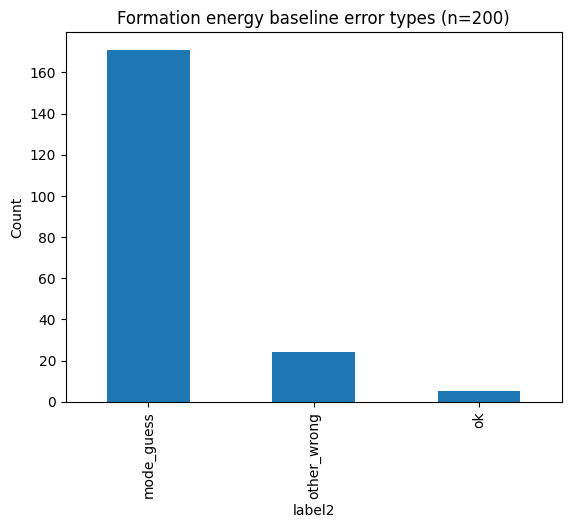

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("baseline_fe_200_labeled_step3.csv")
counts = df["label2"].value_counts()

plt.figure()
counts.plot(kind="bar")
plt.ylabel("Count")
plt.title("Formation energy baseline error types (n=200)")
plt.show()